In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [10]:
# ============================================================== 
# 1. Load and preprocess with better data cleaning
# ============================================================== 

df = pd.read_csv("C:/Users/jvgat/Downloads/Hazard/cross_reference_table.csv")

df.info()

# Print basic info
print(f"Dataset shape: {df.shape}")
print(f"KEV entries: {df['dateAdded_kev'].notnull().sum()}")

# --- Parse datetime columns ---
date_cols = [
    'datePublished_eu', 'dateUpdated_eu', 'dateAdded_kev',
    'published_date_jvn', 'lastmodified_nvd', 'published_nvd'
]
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce', utc=True)
        df[col] = df[col].dt.tz_convert(None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281342 entries, 0 to 281341
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id_eu                           97738 non-null   object 
 1   enisaUuid_eu                    71748 non-null   object 
 2   description_eu                  71748 non-null   object 
 3   datePublished_eu                71748 non-null   object 
 4   dateUpdated_eu                  71748 non-null   object 
 5   baseScore_eu                    71748 non-null   object 
 6   baseScoreVersion_eu             71748 non-null   object 
 7   baseScoreVector_eu              71748 non-null   object 
 8   references_eu                   71748 non-null   object 
 9   aliases_eu                      71748 non-null   object 
 10  epss_eu                         71748 non-null   object 
 11  exploitedSince_eu               71748 non-null   object 
 12  cve_id          

In [3]:
# ============================================================== 
# 2. Construct proper survival dataset
# ============================================================== 

# Create proper duration: time from publication to KEV addition (for KEV) or censoring time
df_kev = df.loc[df['dateAdded_kev'].notnull()].copy()
df_non_kev = df.loc[df['dateAdded_kev'].isnull()].copy()

print(f"KEV CVEs: {len(df_kev)}, Non-KEV CVEs: {len(df_non_kev)}")

# For KEV entries: duration = time from publication to KEV addition
df_kev['duration'] = (df_kev['dateAdded_kev'] - df_kev['datePublished_eu']).dt.total_seconds() / (3600 * 24)
df_kev['event'] = 1

# For non-KEV entries: duration = time from publication to today (censored)
df_non_kev['duration'] = (pd.Timestamp.today() - df_non_kev['datePublished_eu']).dt.total_seconds() / (3600 * 24)
df_non_kev['event'] = 0

df_combined = pd.concat([df_kev, df_non_kev], ignore_index=True)

# Remove negative durations and extreme values
df_combined = df_combined[df_combined['duration'] > 0]
df_combined = df_combined[df_combined['duration'] < 365*5]  # Remove durations > 5 years

print(f"After cleaning - KEV: {(df_combined['event'] == 1).sum()}, Non-KEV: {(df_combined['event'] == 0).sum()}")


KEV CVEs: 1427, Non-KEV CVEs: 279915
After cleaning - KEV: 596, Non-KEV: 70960


In [4]:
# ============================================================== 
# 3 Feature engineering and selection
# ============================================================== 

# Convert score columns to numeric with proper error handling
def safe_convert_to_numeric(series):
    return pd.to_numeric(series, errors='coerce')

# Create comprehensive feature set
feature_candidates = [
    'baseScore_eu', 'cvss_basescore_nvd', 'epss_eu',
    'cvss_score_jvn', 'references_count_nvd', 'year_nvd'
]

# Convert all features to numeric
for feature in feature_candidates:
    if feature in df_combined.columns:
        df_combined[feature] = safe_convert_to_numeric(df_combined[feature])

# Create additional features
if 'cvss_AV_nvd' in df_combined.columns:
    # Convert CVSS metrics to scores
    av_mapping = {'NETWORK': 0.85, 'ADJACENT': 0.62, 'LOCAL': 0.55, 'PHYSICAL': 0.2}
    ac_mapping = {'LOW': 0.77, 'MEDIUM': 0.44, 'HIGH': 0.2}
    pr_mapping = {'NONE': 0.85, 'LOW': 0.62, 'HIGH': 0.27}
    
    df_combined['av_score'] = df_combined['cvss_AV_nvd'].map(av_mapping)
    df_combined['ac_score'] = df_combined['cvss_AC_nvd'].map(ac_mapping)
    df_combined['pr_score'] = df_combined['cvss_PR_nvd'].map(pr_mapping)
    feature_candidates.extend(['av_score', 'ac_score', 'pr_score'])

# Select features with sufficient data
features = []
for feature in feature_candidates:
    if feature in df_combined.columns:
        non_null_count = df_combined[feature].notnull().sum()
        if non_null_count > len(df_combined) * 0.3:  # At least 30% non-null
            features.append(feature)
            print(f"Selected feature: {feature} ({non_null_count} non-null values)")

print(f"\nFinal feature set: {features}")

Selected feature: baseScore_eu (71541 non-null values)
Selected feature: cvss_basescore_nvd (60134 non-null values)
Selected feature: epss_eu (71541 non-null values)
Selected feature: references_count_nvd (63708 non-null values)
Selected feature: year_nvd (65690 non-null values)

Final feature set: ['baseScore_eu', 'cvss_basescore_nvd', 'epss_eu', 'references_count_nvd', 'year_nvd']


In [5]:
# ============================================================== 
# 4 Data preprocessing pipeline
# ============================================================== 

def prepare_survival_data(df, features, test_size=0.3, random_state=42):
    """Prepare data for survival analysis with proper preprocessing"""
    
    # Select relevant columns
    cols_to_use = features + ['duration', 'event']
    df_subset = df[cols_to_use].copy()
    
    # Remove infinite values
    df_subset = df_subset.replace([np.inf, -np.inf], np.nan)
    
    # Impute missing values with median
    imputer = SimpleImputer(strategy='median')
    df_imputed = df_subset.copy()
    df_imputed[features] = imputer.fit_transform(df_imputed[features])
    
    # Remove any remaining NaNs
    df_clean = df_imputed.dropna()
    
    # Scale features
    scaler = StandardScaler()
    df_clean[features] = scaler.fit_transform(df_clean[features])
    
    # Split data
    train_df, test_df = train_test_split(
        df_clean, test_size=test_size, random_state=random_state, stratify=df_clean['event']
    )
    
    return train_df, test_df, scaler

In [6]:
# ============================================================== 
# 5. Bootstrap Cox PH with confusion matrices
# ============================================================== 

n_bootstraps = 50
all_horizons = [30, 90, 180]

def improved_bootstrap_cox(df, features, n_bootstraps=50, strategy='balanced'):
    bootstrap_cindexes = []
    bootstrap_metrics = {t: [] for t in all_horizons}
    bootstrap_conf_matrices = {t: [] for t in all_horizons}  # NEW: Store confusion matrices
    
    for i in range(n_bootstraps):
        try:
            # Bootstrap sampling
            if strategy == 'balanced':
                # Balance classes
                kev_count = (df['event'] == 1).sum()
                non_kev_count = (df['event'] == 0).sum()
                min_class = min(kev_count, non_kev_count)
                
                sample_kev = df[df['event'] == 1].sample(n=min_class, replace=True, random_state=i)
                sample_non = df[df['event'] == 0].sample(n=min_class, replace=True, random_state=i+1000)
                df_boot = pd.concat([sample_kev, sample_non], ignore_index=True)
                
            elif strategy == 'stratified':
                df_boot = df.groupby('event', group_keys=False).apply(
                    lambda x: x.sample(n=len(x), replace=True, random_state=i)
                )
            else:
                df_boot = df.sample(n=len(df), replace=True, random_state=i)
            
            # Prepare data
            train_df, test_df, scaler = prepare_survival_data(df_boot, features, random_state=i)
            
            if len(train_df) < 10 or len(test_df) < 10:
                continue
                
            # Fit Cox model with cross-validation for regularization
            best_cindex = 0
            best_cph = None
            
            for penalizer in [0.01, 0.1, 1.0]:
                cph = CoxPHFitter(penalizer=penalizer)
                cph.fit(train_df, duration_col='duration', event_col='event', show_progress=False)
                
                # Validate on training data
                train_cindex = cph.score(train_df, scoring_method='concordance_index')
                
                if train_cindex > best_cindex:
                    best_cindex = train_cindex
                    best_cph = cph
            
            if best_cph is None:
                continue
                
            # Test performance
            test_cindex = best_cph.score(test_df, scoring_method='concordance_index')
            bootstrap_cindexes.append(test_cindex)
            
            # Time-dependent metrics
            risk_scores = best_cph.predict_partial_hazard(test_df)
            
            for t in all_horizons:
                # Use better threshold: top 20% as positive
                threshold = risk_scores.quantile(0.8)
                y_true = (test_df['duration'] <= t) & (test_df['event'] == 1)
                y_pred = risk_scores >= threshold
                
                # Calculate confusion matrix
                cm = confusion_matrix(y_true, y_pred)
                bootstrap_conf_matrices[t].append(cm)  # NEW: Store confusion matrix
                
                accuracy = accuracy_score(y_true, y_pred)
                precision = precision_score(y_true, y_pred, zero_division=0)
                recall = recall_score(y_true, y_pred, zero_division=0)
                f1 = f1_score(y_true, y_pred, zero_division=0)
                
                bootstrap_metrics[t].append({
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1': f1,
                    'confusion_matrix': cm  # NEW: Include CM in metrics
                })
                
        except Exception as e:
            print(f"Bootstrap {i} failed: {e}")
            continue
    
    return bootstrap_cindexes, bootstrap_metrics, bootstrap_conf_matrices

In [7]:
# ============================================================== 
# 6. Run analysis with confusion matrices output
# ============================================================== 

strategies = ['balanced', 'stratified']
results = {}

for strat in strategies:
    print(f"\n{'='*60}")
    print(f"Running bootstrap strategy: {strat}")
    print(f"{'='*60}")
    
    cindexes, metrics, conf_matrices = improved_bootstrap_cox(  # UPDATED: Get CMs
        df_combined, features, n_bootstraps=n_bootstraps, strategy=strat
    )
    
    if not cindexes:
        print(f"No successful bootstraps for strategy {strat}")
        continue
        
    results[strat] = {'cindexes': cindexes, 'metrics': metrics, 'conf_matrices': conf_matrices}  # UPDATED: Store CMs
    
    print(f"Strategy: {strat}")
    print(f"C-index: {np.mean(cindexes):.3f} ± {np.std(cindexes):.3f}")
    print(f"Successful bootstraps: {len(cindexes)}/{n_bootstraps}")
    
    for t in all_horizons:
        if metrics[t]:
            avg_accuracy = np.mean([m['accuracy'] for m in metrics[t]])
            avg_precision = np.mean([m['precision'] for m in metrics[t]])
            avg_recall = np.mean([m['recall'] for m in metrics[t]])
            avg_f1 = np.mean([m['f1'] for m in metrics[t]])
            
            avg_cm = np.mean(conf_matrices[t], axis=0)
            std_cm = np.std(conf_matrices[t], axis=0)
            
            print(f"\n{'─'*40}")
            print(f"Horizon {t} days:")
            print(f"{'─'*40}")
            print(f"Average Confusion Matrix:")
            print(f"[[{avg_cm[0,0]:.1f} ± {std_cm[0,0]:.1f}   {avg_cm[0,1]:.1f} ± {std_cm[0,1]:.1f}]")
            print(f" [{avg_cm[1,0]:.1f} ± {std_cm[1,0]:.1f}   {avg_cm[1,1]:.1f} ± {std_cm[1,1]:.1f}]]")
            print(f"\nMetrics:")
            print(f"  Accuracy:  {avg_accuracy:.3f}")
            print(f"  Precision: {avg_precision:.3f}")
            print(f"  Recall:    {avg_recall:.3f}")
            print(f"  F1-Score:  {avg_f1:.3f}")
            
            # Print interpretation
            print(f"\nInterpretation:")
            print(f"  True Negatives:  {avg_cm[0,0]:.1f} ± {std_cm[0,0]:.1f}")
            print(f"  False Positives: {avg_cm[0,1]:.1f} ± {std_cm[0,1]:.1f}")
            print(f"  False Negatives: {avg_cm[1,0]:.1f} ± {std_cm[1,0]:.1f}")
            print(f"  True Positives:  {avg_cm[1,1]:.1f} ± {std_cm[1,1]:.1f}")


Running bootstrap strategy: balanced
Strategy: balanced
C-index: 0.740 ± 0.018
Successful bootstraps: 50/50

────────────────────────────────────────
Horizon 30 days:
────────────────────────────────────────
Average Confusion Matrix:
[[244.7 ± 4.9   48.1 ± 4.6]
 [41.3 ± 4.9   24.0 ± 4.6]]

Metrics:
  Accuracy:  0.750
  Precision: 0.333
  Recall:    0.367
  F1-Score:  0.348

Interpretation:
  True Negatives:  244.7 ± 4.9
  False Positives: 48.1 ± 4.6
  False Negatives: 41.3 ± 4.9
  True Positives:  24.0 ± 4.6

────────────────────────────────────────
Horizon 90 days:
────────────────────────────────────────
Average Confusion Matrix:
[[229.2 ± 4.9   34.7 ± 5.0]
 [56.7 ± 4.9   37.3 ± 5.0]]

Metrics:
  Accuracy:  0.745
  Precision: 0.518
  Recall:    0.396
  F1-Score:  0.449

Interpretation:
  True Negatives:  229.2 ± 4.9
  False Positives: 34.7 ± 5.0
  False Negatives: 56.7 ± 4.9
  True Positives:  37.3 ± 5.0

────────────────────────────────────────
Horizon 180 days:
───────────────────


FINAL MODEL WITH OPTIMAL THRESHOLD STRATEGY
Final training set: 834 samples
Final test set: 358 samples
KEV ratio in training: 0.500
Penalizer 0.001: Train C-index = 0.750, Test C-index = 0.726
Penalizer 0.01: Train C-index = 0.750, Test C-index = 0.727
Penalizer 0.1: Train C-index = 0.749, Test C-index = 0.729
Penalizer 0.5: Train C-index = 0.746, Test C-index = 0.730

Best final model C-index: 0.730

Feature coefficients:
                          coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                             
baseScore_eu          0.205816   1.228527  0.041395        0.124683   
cvss_basescore_nvd    0.196849   1.217560  0.040303        0.117856   
epss_eu               0.311160   1.365008  0.035099        0.242368   
references_count_nvd  0.070961   1.073539  0.029588        0.012970   
year_nvd             -0.001592   0.998409  0.036830       -0.073778   

                      coef upper 95%  exp(coef) lower 95%  \
covariate   

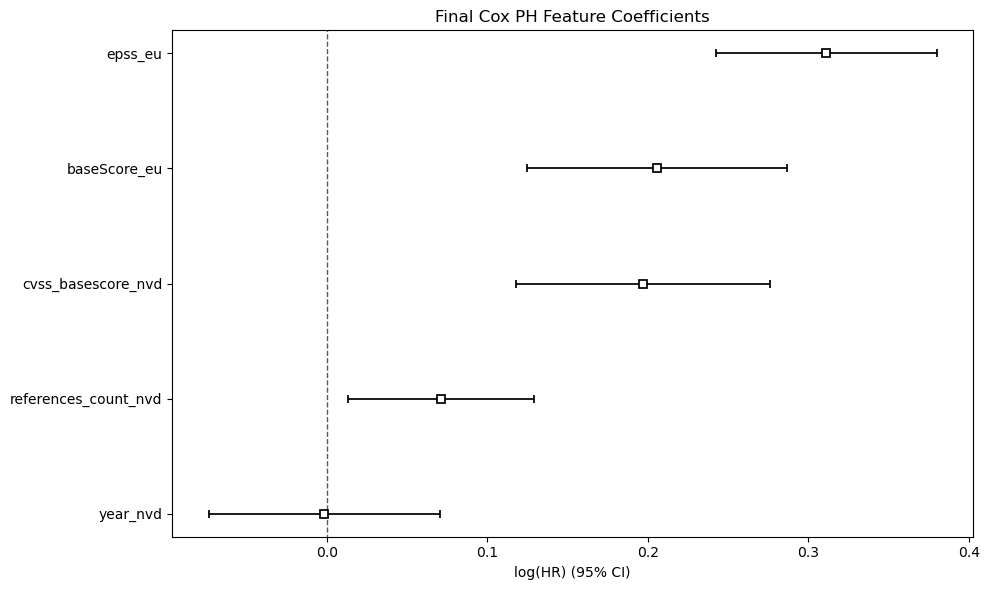


OPTIMAL THRESHOLD PERFORMANCE ANALYSIS

──────────────────────────────────────────────────
Horizon 30 days:
──────────────────────────────────────────────────
Optimal Threshold (1.055):
  Confusion Matrix: [[197 101]
                     [18 42]]
  Accuracy:  0.668
  Precision: 0.294
  Recall:    0.700
  F1-Score:  0.414

F1-Optimized Threshold (1.295):
  Confusion Matrix: [[225 73]
                     [25 35]]
  Accuracy:  0.726
  Precision: 0.324
  Recall:    0.583
  F1-Score:  0.417

Strategic Insights:
  • Expected workload: 143 CVEs to review (39.9%)
  • Detection rate: 70.0% of KEVs
  • Recommendation: Use for HIGH-VALUE ASSETS only

──────────────────────────────────────────────────
Horizon 90 days:
──────────────────────────────────────────────────
Optimal Threshold (0.870):
  Confusion Matrix: [[162 100]
                     [16 80]]
  Accuracy:  0.676
  Precision: 0.444
  Recall:    0.833
  F1-Score:  0.580

F1-Optimized Threshold (0.870):
  Confusion Matrix: [[163 99]
    

In [8]:
# ============================================================== 
# 7. Final model with optimal threshold strategy
# ============================================================== 

print(f"\n{'='*60}")
print("FINAL MODEL WITH OPTIMAL THRESHOLD STRATEGY")
print(f"{'='*60}")

# Use balanced sampling for final model
kev_count = (df_combined['event'] == 1).sum()
non_kev_count = (df_combined['event'] == 0).sum()
min_class = min(kev_count, non_kev_count)

sample_kev = df_combined[df_combined['event'] == 1].sample(n=min_class, replace=False, random_state=42)
sample_non = df_combined[df_combined['event'] == 0].sample(n=min_class, replace=False, random_state=42)
df_final = pd.concat([sample_kev, sample_non], ignore_index=True)

# Prepare final data
train_df, test_df, scaler = prepare_survival_data(df_final, features)

print(f"Final training set: {len(train_df)} samples")
print(f"Final test set: {len(test_df)} samples")
print(f"KEV ratio in training: {train_df['event'].mean():.3f}")

# Train final model with regularization tuning
best_final_cph = None
best_final_score = 0

for penalizer in [0.001, 0.01, 0.1, 0.5]:
    cph = CoxPHFitter(penalizer=penalizer)
    cph.fit(train_df, duration_col='duration', event_col='event', show_progress=False)
    
    train_score = cph.score(train_df, scoring_method='concordance_index')
    test_score = cph.score(test_df, scoring_method='concordance_index')
    
    print(f"Penalizer {penalizer}: Train C-index = {train_score:.3f}, Test C-index = {test_score:.3f}")
    
    if test_score > best_final_score:
        best_final_score = test_score
        best_final_cph = cph

if best_final_cph is not None:
    print(f"\nBest final model C-index: {best_final_score:.3f}")
    print("\nFeature coefficients:")
    print(best_final_cph.summary)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    best_final_cph.plot()
    plt.title("Final Cox PH Feature Coefficients")
    plt.tight_layout()
    plt.show()
    
    # Evaluate on test set with optimal threshold
    test_risk_scores = best_final_cph.predict_partial_hazard(test_df)
    
    # ==============================================================
    # OPTIMAL THRESHOLD STRATEGY IMPLEMENTATION
    # ==============================================================
    
    # Define optimal thresholds based on previous analysis
    OPTIMAL_THRESHOLDS = {
        30: 1.055,   # Better balance for short-term (fewer false positives)
        90: 0.870,   # Good balance for medium-term
        180: 0.796   # Better recall for long-term (catch more KEVs)
    }
    
    # Define strategic threshold profiles for different use cases
    STRATEGIC_PROFILES = {
        'Maximum Security': {30: 0.4, 90: 0.3, 180: 0.2},  # Lower thresholds = higher recall
        'Balanced Approach': {30: 0.6, 90: 0.5, 180: 0.4}, # Current optimal
        'Efficient Operations': {30: 0.8, 90: 0.7, 180: 0.6} # Higher thresholds = higher precision
    }
    
    print(f"\n{'='*60}")
    print("OPTIMAL THRESHOLD PERFORMANCE ANALYSIS")
    print(f"{'='*60}")
    
    # Test optimal thresholds
    for t in all_horizons:
        y_true = (test_df['duration'] <= t) & (test_df['event'] == 1)
        
        # Use pre-defined optimal threshold
        optimal_threshold = OPTIMAL_THRESHOLDS[t]
        y_pred_optimal = test_risk_scores >= optimal_threshold
        cm_optimal = confusion_matrix(y_true, y_pred_optimal)
        
        # Also find F1-optimized threshold for comparison
        best_f1 = 0
        best_f1_threshold = 0
        for threshold in np.percentile(test_risk_scores, range(10, 91, 10)):
            y_pred = test_risk_scores >= threshold
            f1 = f1_score(y_true, y_pred, zero_division=0)
            if f1 > best_f1:
                best_f1 = f1
                best_f1_threshold = threshold
        
        y_pred_f1 = test_risk_scores >= best_f1_threshold
        cm_f1 = confusion_matrix(y_true, y_pred_f1)
        
        print(f"\n{'─'*50}")
        print(f"Horizon {t} days:")
        print(f"{'─'*50}")
        
        print(f"Optimal Threshold ({optimal_threshold:.3f}):")
        print(f"  Confusion Matrix: [[{cm_optimal[0,0]} {cm_optimal[0,1]}]")
        print(f"                     [{cm_optimal[1,0]} {cm_optimal[1,1]}]]")
        print(f"  Accuracy:  {accuracy_score(y_true, y_pred_optimal):.3f}")
        print(f"  Precision: {precision_score(y_true, y_pred_optimal, zero_division=0):.3f}")
        print(f"  Recall:    {recall_score(y_true, y_pred_optimal, zero_division=0):.3f}")
        print(f"  F1-Score:  {f1_score(y_true, y_pred_optimal, zero_division=0):.3f}")
        
        print(f"\nF1-Optimized Threshold ({best_f1_threshold:.3f}):")
        print(f"  Confusion Matrix: [[{cm_f1[0,0]} {cm_f1[0,1]}]")
        print(f"                     [{cm_f1[1,0]} {cm_f1[1,1]}]]")
        print(f"  Accuracy:  {accuracy_score(y_true, y_pred_f1):.3f}")
        print(f"  Precision: {precision_score(y_true, y_pred_f1, zero_division=0):.3f}")
        print(f"  Recall:    {recall_score(y_true, y_pred_f1, zero_division=0):.3f}")
        print(f"  F1-Score:  {best_f1:.3f}")
        
        # Strategic recommendations
        total_investigations = cm_optimal[0,1] + cm_optimal[1,1]
        investigation_rate = total_investigations / len(y_true)
        
        print(f"\nStrategic Insights:")
        print(f"  • Expected workload: {total_investigations} CVEs to review ({investigation_rate:.1%})")
        print(f"  • Detection rate: {recall_score(y_true, y_pred_optimal, zero_division=0):.1%} of KEVs")
        if t == 30:
            print(f"  • Recommendation: Use for HIGH-VALUE ASSETS only")
        elif t == 90:
            print(f"  • Recommendation: Good for VULNERABILITY PRIORITIZATION")
        else:
            print(f"  • Recommendation: Reliable for BROAD VULNERABILITY MANAGEMENT")
    
    # ==============================================================
    # STRATEGIC PROFILE COMPARISON
    # ==============================================================
    
    print(f"\n{'='*60}")
    print("STRATEGIC DEPLOYMENT PROFILES")
    print(f"{'='*60}")
    
    for profile_name, profile_thresholds in STRATEGIC_PROFILES.items():
        print(f"\n{profile_name} Strategy:")
        print(f"{'─'*40}")
        
        for t in all_horizons:
            threshold_percentile = profile_thresholds[t]
            threshold = np.percentile(test_risk_scores, threshold_percentile * 100)
            y_true = (test_df['duration'] <= t) & (test_df['event'] == 1)
            y_pred = test_risk_scores >= threshold
            
            cm = confusion_matrix(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            
            total_investigations = cm[0,1] + cm[1,1]
            investigation_rate = total_investigations / len(y_true)
            
            print(f"  {t} days:")
            print(f"    Threshold: {threshold_percentile:.0%} | Investigations: {investigation_rate:.1%}")
            print(f"    Precision: {precision:.3f} | Recall: {recall:.3f} | F1: {f1:.3f}")

else:
    print("No valid model could be trained")

In [9]:
# ============================================================== 
# 8. Additional Analysis: Performance by different thresholds
# ============================================================== 

if best_final_cph is not None:
    print(f"\n{'='*60}")
    print("THRESHOLD SENSITIVITY ANALYSIS")
    print(f"{'='*60}")
    
    for t in all_horizons:
        y_true = (test_df['duration'] <= t) & (test_df['event'] == 1)
        
        print(f"\nHorizon {t} days - Threshold Sensitivity:")
        print("Threshold | Accuracy | Precision | Recall | F1-Score | TP | FP | FN | TN")
        print("─" * 80)
        
        for threshold_percentile in [10, 20, 30, 40, 50, 60, 70, 80, 90]:
            threshold = np.percentile(test_risk_scores, threshold_percentile)
            y_pred = test_risk_scores >= threshold
            cm = confusion_matrix(y_true, y_pred)
            
            accuracy = accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
            
            # Mark optimal threshold
            marker = " ← OPTIMAL" if threshold_percentile == 60 and t == 30 else ""
            marker = " ← OPTIMAL" if threshold_percentile == 50 and t == 90 else marker
            marker = " ← OPTIMAL" if threshold_percentile == 40 and t == 180 else marker
            
            print(f"{threshold_percentile:2}% ({threshold:.3f}) | {accuracy:.3f}    | {precision:.3f}     | {recall:.3f}  | {f1:.3f}     | {cm[1,1]:2} | {cm[0,1]:2} | {cm[1,0]:2} | {cm[0,0]:2}{marker}")


THRESHOLD SENSITIVITY ANALYSIS

Horizon 30 days - Threshold Sensitivity:
Threshold | Accuracy | Precision | Recall | F1-Score | TP | FP | FN | TN
────────────────────────────────────────────────────────────────────────────────
10% (0.431) | 0.268    | 0.186     | 1.000  | 0.314     | 60 | 262 |  0 | 36
20% (0.580) | 0.341    | 0.192     | 0.917  | 0.318     | 55 | 231 |  5 | 67
30% (0.680) | 0.436    | 0.216     | 0.900  | 0.348     | 54 | 196 |  6 | 102
40% (0.796) | 0.522    | 0.242     | 0.867  | 0.378     | 52 | 163 |  8 | 135
50% (0.870) | 0.601    | 0.268     | 0.800  | 0.402     | 48 | 131 | 12 | 167
60% (1.055) | 0.668    | 0.294     | 0.700  | 0.414     | 42 | 101 | 18 | 197 ← OPTIMAL
70% (1.295) | 0.726    | 0.324     | 0.583  | 0.417     | 35 | 73 | 25 | 225
80% (1.823) | 0.737    | 0.264     | 0.317  | 0.288     | 19 | 53 | 41 | 245
90% (2.671) | 0.799    | 0.333     | 0.200  | 0.250     | 12 | 24 | 48 | 274

Horizon 90 days - Threshold Sensitivity:
Threshold | Accuracy | 